<a href="https://colab.research.google.com/github/WLAraujo/min_dados_ufabc/blob/main/05_classificadores_bayesianos_avaliacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificadores Bayesianos

Em um problema de classificação queremos encontrar qual é a classe c mais provável, dentre as possíveis classes C, ou seja, queremos encontrar uma regra de decisão que minimiza o erro.

**Classificadores Bayesianos** são classificadores estatísticos que classificam objetos numa determinada classe baseando-se na probabilidade deste objeto pertencer a essa classe.

Os classificadores bayesianos são ditos ingênuos (*naive*) quando supõem como hipótese que o valor de um atributo não influencia no valor de outros atributos. Essa hipótese facilita os cálculos envolvidos na classificação.

Suponha que X é uma tupla a ser classificada em uma das seguintes classes: c1, c2, ..., cn. O classificador bayesiano vai classificar X na classe c para a qual a probabilidade condicional P[c|X] é a mais alta possível.

A **análise discriminante** é uma técnica da estatística utilizada para discriminar e classificar objetos. Ela estuda a separação de objetos de uma população em duas ou mais classes. A discriminação ou separação é a primeira etapa, sendo a parte exploratória da análise e consiste em procurar características capazes de serem utilizadas para alocar objetos em diferentes grupos previamente definidos. A classificação ou alocação pode ser definida como um conjunto de regras que serão usadas para alocar novos objetos. 

Aplicar a análise discriminante consiste em se obter uma combinação linear de características observadas que apresente maior poder de discriminação entre populações. Esta combinação linear é denominada função discriminante. Tal função tem a propriedade de minimizar as probabilidades de má classificação.

Neste caderno, vamos utilizar a biblioteca [scikit-learn](https://scikit-learn.org/) para analisar alguns classificadores Bayesianos, mais especificamente discriminante linear, o discriminanto quadrático e o Naïve Bayes.

* Em **Análise de Discriminante Linear**, assumimos que cada classe pode ser estimada por uma distribuição Gaussiana, com a mesma covariância para todas as classes

* Em **Análise de Discriminante Quadrática**, também usamos Gaussianas, mas a matriz de covariância em cada classe é diferente

* No **Naive Bayes**, assuma que cada distribuição de densidade da classe são independentes

## 1 - Importando os pacotes que serão usados

In [37]:
# Discriminante Linear e Quadrático
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
# Naive Bayes, com distribuição gaussiana
from sklearn.naive_bayes import GaussianNB
# Transformação de escala nos atributos para que tenham média zero e desvio padrão 1
from sklearn.preprocessing import StandardScaler
# Dados artificiais do sitem OpenML
from sklearn.datasets import make_moons, make_circles, fetch_openml
# Funções de plotagem
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
# Métricas de avaliaçao dos modelos
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import make_scorer
# Avaliação cruzada para testes
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
# Manipulação de dados
import numpy as np
import pandas as pd
from collections import Counter

## 2 - Modelo de Discriminante Linear

### 2.1 - Criação de dados artificiais

In [8]:
# Definindo função que cria dados artificais que podem ser classificados em duas classes
# Vamos representar as classes numericamente através de 0 e 1
# Os dados sorteados para as classes virão de normais multivariadas
# A função aceita dois vetores de média, o número de exemplos de cada classe e duas matrizes de covariância
def make_gaussian(mean_1,mean_2,n_samples,sigma_1,sigma_2=None):
  # Primeiro sorteamos dados da primeira classe
  valores_1 = np.random.multivariate_normal(mean_1, sigma_1, size=n_samples)
  if (sigma_2):
    # Caso tenhamos sigma_2
    valores_2 = np.random.multivariate_normal(mean_2, sigma_2, size=n_samples)
  else:
    # Caso não temos sigma_2
    valores_2 = np.random.multivariate_normal(mean_2, sigma_1, size=n_samples)
  # Vetores para representar as classes através de 0 e 1
  classe_1 = np.zeros(n_samples)
  classe_2 = np.ones(n_samples)
  # Junta os dados de valor com a classificação
  return((np.vstack((valores_1,valores_2)),np.hstack((classe_1,classe_2))))

In [9]:
# Criando base de dados com dois atributos e covariância 0 entre eles
# A classe 1 terá média (0,0) e a classe 2 terá média (3,3)
# x indica os pares coletados com base na distribuição normal, já y indica a classe de cada um desses pares
x, y = make_gaussian([0,0],[3,3],300,[[2,0],[0,2]])

### 2.2 - Fronteira usando Discriminante Linear

Agora vamos explorar discriminante linear. O scikit-learn tem uma interface uniforme para todos os algoritmos implementados. O método fit é  é a interface padrão da scikit learn para criação de modelos.

In [10]:
# Criação de modelo de discriminante linear com base nos dados
dis_lin = LinearDiscriminantAnalysis()
dis_lin.fit(x,y)

LinearDiscriminantAnalysis()

### 2.3 Visualização da fronteira

In [13]:
# A fronteira de decisão criada entre as classes é linear com duas variáveis
# Dito isso a reta possui dois coeficientes lineares
# Obtendo os coeficientes da reta que representa a fronteira de decisão
a1, a2 = dis_lin.coef_[0]

In [12]:
#Nesse elemento é onde encontramos o coeficiente angular da reta
b = dis_lin.intercept_

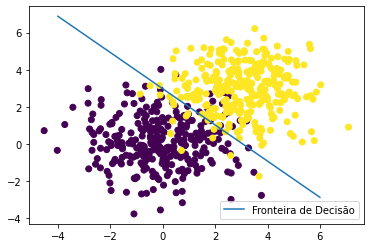

In [15]:
# Plotagem do gráfico que vai nos apresentar os dados e a fronteira de decisão
# Plotagem dos dados
plt.scatter(x[:,0],x[:,1],c=y)
# Plotagem da fronteira de decisão
x1 = np.arange(-4,7)
x2 = - (a1/a2)* x1 - b/a2
plt.plot(x1,x2,label='Fronteira de Decisão') 
plt.legend()
plt.show()

## 3 - Comparação de modelos

Vamos fazer uma comparação dos três classificadores (Discriminante Linear, Discriminante Quadrático e Naive Bayes) em diferentes conjuntos de dados artificiais. Primeiramente, criamos 5 conjuntos de dados artificiais diferentes:

- Duas meias luas
- Círculos concêntricos
- Duas Gaussianas, com igual variância e sem covariância
- Duas Gaussianas, com igual variância e covariância para ambas as classes
- Duas Gaussianas, com variância e covariância diferentes para ambas as classes:

In [16]:
# Criação dos dataset através de funções, veja que estamos usando ruído para ficar um pouco mais aleatório
# Também veja que todos os datasets vão possuir 300 amostras
datasets = {
    'Duas Meias Luas' : make_moons(noise=0.2, random_state=0, n_samples=300),
    'Círculos' : make_circles(noise=0.2, factor=0.5, random_state=1, n_samples=300),
    'Sem Covariância':  make_gaussian([0,0],[3,3],300,[[2,0],[0,2]]),
    'Igual Covariância':  make_gaussian([0,0],[2,2],300,[[2,-1],[-1,2]]),
    'Covariâncias Diferentes':  make_gaussian([0,0],[1,1],300,[[2,1],[1,2]],[[2,-1],[-1,2]])
  }

Agora vamos criar os três classificadores:

- Naïve Bayes
- Discriminante Linear
- Discrimonante Quadrático

In [17]:
classificadores = {
    'Naive Bayes (Gaussian)' : GaussianNB(),
    'Discriminante Linear' : LinearDiscriminantAnalysis(),
    'Discriminante Quadrático' : QuadraticDiscriminantAnalysis()
  }

Vamos agora criar um grid de gráficos onde a tonalidade indica a probabilidade de cada região pertencer a cada uma das classes, bem como a fronteira de decisão.

In [24]:
#Função que vai ser usada para fit dos modelos e plot dos gráficos em um grid
def fit_and_plot(x,y,classificador,ax,nome):
  classificador.fit(x,y)
  # Determinação do grid de pontos do plano de fundo com resolução h (0.1)
  h = 0.1
  x1, x2 = np.meshgrid(np.arange(-4, 4, h),
                       np.arange(-4, 4, h))
  # Predição da probabilidade através do modelo criado
  Z = classificador.predict_proba(np.c_[x1.ravel(), x2.ravel()])[:, 1]
  Z = Z.reshape(x1.shape)
  # Plotando o plano de fundo com indicação de probabilidade por região
  ax.pcolormesh(x1, x2, Z, cmap='red_blue_classes',
                norm=colors.Normalize(0., 1.), zorder=0)
  # Plotando os contornos das regiões associadas às classificações em si
  ax.contour(x1, x2, Z, [0.5], linewidths=2., colors='white')
  # Plot dos pontos dos valores em si
  ax.scatter(x[:,0],x[:,1],c = y, cmap=plt.cm.RdBu)
  ax.set_title(nome)

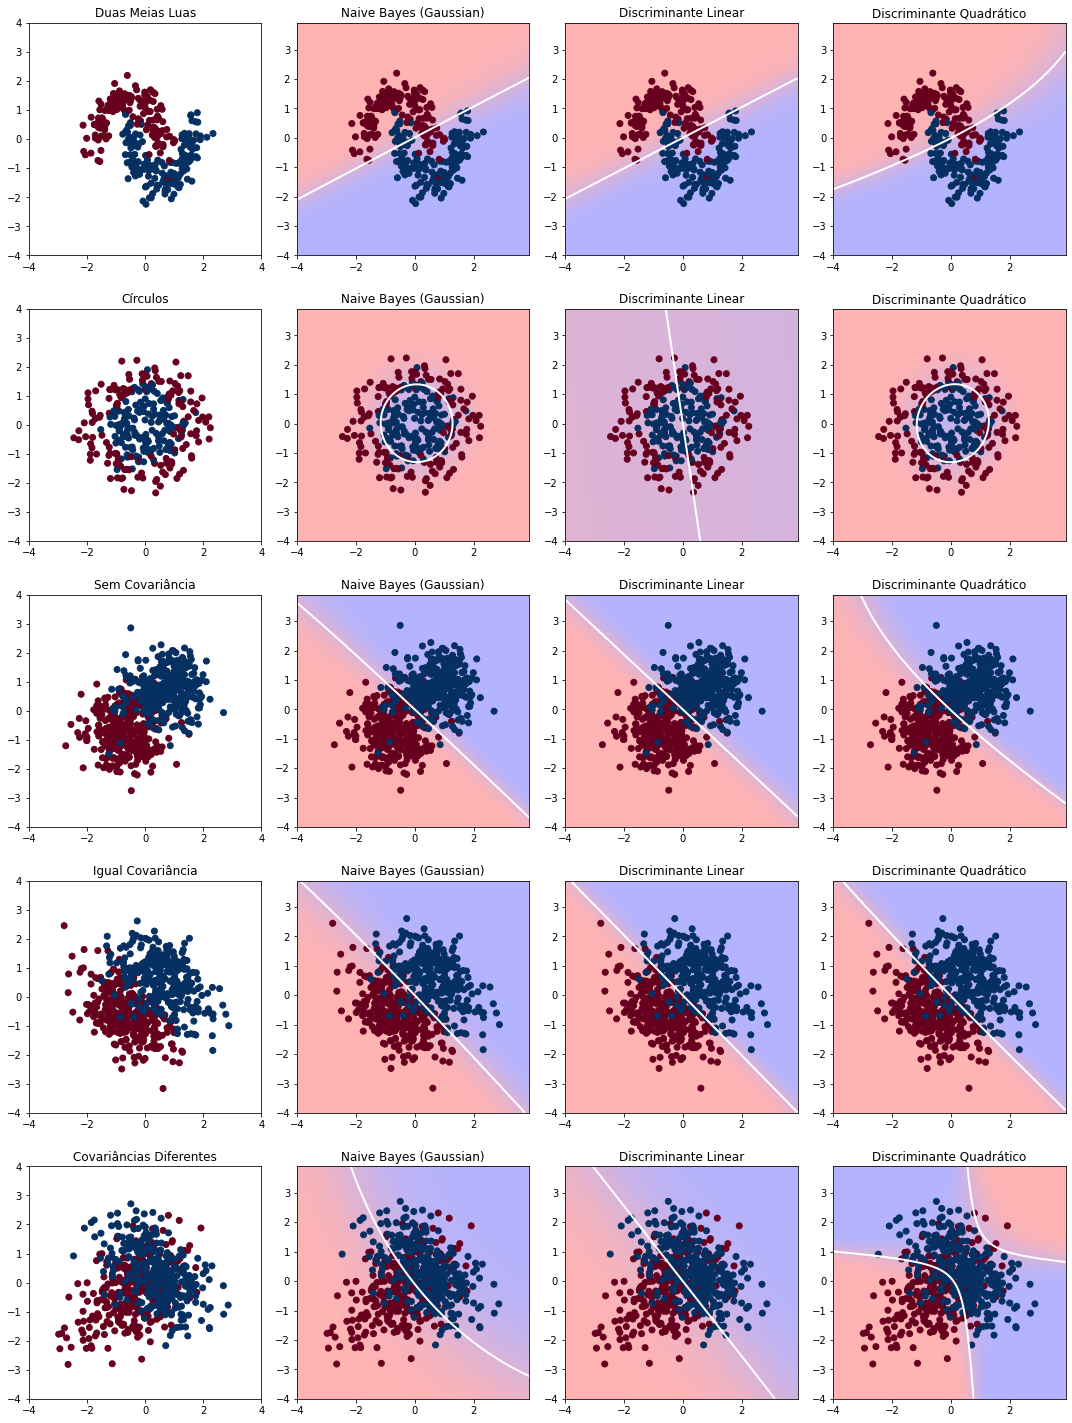

In [25]:
# Definições do plot
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)
figure = plt.figure(figsize=(15, 20))

# Variável usada para controlar a posição de cada gráfico
i=1 

# Para cada conjunto de dados vamos realizar o plot em alguma posição do grid
for nome, dataset in datasets.items():
  X, y = dataset
  X = StandardScaler().fit_transform(X) # Define escala padrão para os vários gráficos
  ax = plt.subplot(len(datasets), len(classificadores) + 1, i,
                   aspect=1,xlim=[-4,4],ylim=[-4,4]) # Gráficos da primeira coluna (sem modelo)
  ax.scatter(X[:,0],X[:,1],c = y,cmap=plt.cm.RdBu) # Definindo cores das classes
  ax.set_title(nome) # Mostrando titulo do dataset
  i+=1
  # Iteração para cada um dos três algoritmos de classificação
  for classificador_nome, classificador in classificadores.items():
    ax = plt.subplot(len(datasets), len(classificadores) + 1, i,aspect=1)
    fit_and_plot(X,y,classificador,ax,classificador_nome) # Gráficos das 3 últimas colunas
    i+=1

plt.tight_layout()
plt.show()

## 4 - Comparação de modelos em conjunto de dados real

Os exemplos anteriores, criados a partir de dados artificiais, são úteis para a visualização de algumas propriedades dos modelos. No exemplo a seguir, veremos uma comparação em um conjunto com dados reais, a respeito da predição de cancer de mama, da universidade de Wisconsin. A descrição dos atributos está [aqui](https://www.openml.org/d/1510).

### 4.1 - Importando e visualizando os dados

In [26]:
# openml é um site com bases de dados que o scikit learn faz interface padronizada
# Vamos fazer a importação desses dados através dessa interface
# https://www.openml.org/s/1510
wdbc = fetch_openml(data_id=1510)

In [27]:
# Vendo o dataset através de um array do numpy
wdbc.data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [28]:
# Vendo o fomato do dataset
wdbc.data.shape

(569, 30)

In [29]:
# Visualizando os valores da classe target do problema
wdbc.target

0      2
1      2
2      2
3      2
4      2
      ..
564    2
565    2
566    2
567    2
568    1
Name: Class, Length: 569, dtype: category
Categories (2, object): ['1', '2']

In [30]:
# Vamos ver os valores únicos das classes e a quantidade de linhas para cada um deles
print(Counter(wdbc.target))

Counter({'1': 357, '2': 212})


### 4.2 - Usando *cross-validation*

Agora, vamos comparar o desempenho desses classificadores usando a **Validação Cruzada** (*cross-validation*). Validação cruzada é um procedimento de treinamento e testes de modelos que serve como alternativa para o o método mais comum que é a divisão do dataset em um conjunto de treino e um conjunto de teste. 

A **k validação cruzada** consiste em dividir o conjunto de treinamento em k partições. Depois, são feitas k iterações e em cada uma delas k-1 partições são usadas para treinamento e a outra partição retante é usada para teste. As avaliações sobre o que foi testado na validação cruzada  são feitas sobre as médias dos valores computados no loop.

Uma das maneiras de usar validação cruzada com o scikit-learn é usar o método `cross_validate`. Por padrão, esse método usa acurária como medida de avaliação. Vamos adicionar um parâmetro para utilizar outras duas medidas.

Lembrando que:
* **Acurácia -** Indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente.
* **Precisão -** Dentre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas.
* **Recall/Sensibilidade -** Dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas.
* **F1-Score -** Média harmônica entre precisão e recall.
* **Coeficiente Kappa -** Trata-se de um método estatístico para avaliar o nível de concordância ou reprodutibilidade entre dois conjuntos de dados.

In [39]:
# Definindo dicionário para as medidas de avaliação e lista para armazenar resultados
scoring = {'accuracy': make_scorer(accuracy_score), 
           'f1': make_scorer(f1_score, pos_label='2'),
           'kappa' : make_scorer(cohen_kappa_score),
           'auc_roc' : make_scorer(roc_auc_score)
           }
results = []

In [ ]:
# Laço sobre classificadores para fazer a validação cruzada considerando cada métrica
for classificador_name, classificador in classificadores.items():
  # Automaticamente faz a validação cruzada com 10 divisões e computa as medidas de avaliação
  tmp = cross_validate(classificador,wdbc.data,wdbc.target,cv=10,scoring=scoring,return_train_score=True)
  #As duas linhas abaixo só servem para indicação do classificador e do fold usado
  tmp['clf'] = [classificador_name]*10
  tmp['fold'] = range(10)
  # Monta uma lista de dataframes para analisarmos os resultados adicionando cada iteração do nosso cross validation
  results.append(pd.DataFrame(tmp)) 

### 4.3 - Visualização dos resultados

In [42]:
# Verificando os resultados
results

[   fit_time  score_time  ...                     clf  fold
 0  0.010404    0.010449  ...  Naive Bayes (Gaussian)     0
 1  0.003263    0.006372  ...  Naive Bayes (Gaussian)     1
 2  0.003191    0.005852  ...  Naive Bayes (Gaussian)     2
 3  0.003171    0.005789  ...  Naive Bayes (Gaussian)     3
 4  0.003157    0.005713  ...  Naive Bayes (Gaussian)     4
 5  0.003211    0.005780  ...  Naive Bayes (Gaussian)     5
 6  0.003148    0.005835  ...  Naive Bayes (Gaussian)     6
 7  0.003232    0.005770  ...  Naive Bayes (Gaussian)     7
 8  0.003604    0.005811  ...  Naive Bayes (Gaussian)     8
 9  0.003941    0.005799  ...  Naive Bayes (Gaussian)     9
 
 [10 rows x 12 columns],
    fit_time  score_time  ...                   clf  fold
 0  0.016102    0.009696  ...  Discriminante Linear     0
 1  0.014638    0.008913  ...  Discriminante Linear     1
 2  0.009588    0.008876  ...  Discriminante Linear     2
 3  0.009716    0.009562  ...  Discriminante Linear     3
 4  0.015123    0.02968

In [44]:
# Concatenando os dataframes em um só
results = pd.concat(results)

In [45]:
# Renomeando colunas
results.rename(columns={'fit_time' : 'train_time' , 'score_time' : 'test_time'}, inplace=True)

In [46]:
# Dataframe final
results

,train_time,test_time,test_accuracy,train_accuracy,test_f1,train_f1,test_kappa,train_kappa,test_auc_roc,train_auc_roc,clf,fold
0,0.010404,0.010449,0.947368,0.939453,0.933333,0.915531,0.889891,0.868439,0.948701,0.928130,Naive Bayes (Gaussian),0
1,0.003263,0.006372,0.877193,0.941406,0.837209,0.918919,0.738703,0.873100,0.866234,0.931840,Naive Bayes (Gaussian),1
2,0.003191,0.005852,0.894737,0.945312,0.842105,0.924731,0.764463,0.881835,0.867063,0.936243,Naive Bayes (Gaussian),2
3,0.003171,0.005789,0.929825,0.941406,0.900000,0.919355,0.846154,0.873395,0.914683,0.932068,Naive Bayes (Gaussian),3
4,0.003157,0.005713,0.947368,0.939453,0.926829,0.915989,0.885772,0.868753,0.938492,0.928390,Naive Bayes (Gaussian),4
5,0.003211,0.005780,0.964912,0.939453,0.950000,0.916442,0.923077,0.869034,0.952381,0.929450,Naive Bayes (Gaussian),5
6,0.003148,0.005835,0.929825,0.943359,0.900000,0.921833,0.846154,0.877484,0.914683,0.933625,Naive Bayes (Gaussian),6
7,0.003232,0.005770,0.964912,0.937500,0.952381,0.913978,0.924603,0.864954,0.962302,0.927892,Naive Bayes (Gaussian),7
8,0.003604,0.005811,0.947368,0.937500,0.930233,0.914439,0.888016,0.865243,0.948413,0.928952,Naive Bayes (Gaussian),8
9,0.003941,0.005799,0.964286,0.939571,0.950000,0.916442,0.922330,0.869179,0.952381,0.929498,Naive Bayes (Gaussian),9


In [47]:
# Transformações para plotar gráfico no seaborn
# Conversão entre dataframe amplo (muitas colunas) para dataframe longo (muitas linhas)
results = pd.melt(results,id_vars=['clf','fold'])

In [48]:
# Vendo novo formato
results

,clf,fold,variable,value
0,Naive Bayes (Gaussian),0,train_time,0.010404
1,Naive Bayes (Gaussian),1,train_time,0.003263
2,Naive Bayes (Gaussian),2,train_time,0.003191
3,Naive Bayes (Gaussian),3,train_time,0.003171
4,Naive Bayes (Gaussian),4,train_time,0.003157
...,...,...,...,...
595,Discriminante Quadrático,5,train_auc_roc,0.967094
596,Discriminante Quadrático,6,train_auc_roc,0.971269
597,Discriminante Quadrático,7,train_auc_roc,0.972827
598,Discriminante Quadrático,8,train_auc_roc,0.969712


In [49]:
# Vamos quebrar a coluna de variável para gerar novas duas colunas
# Uma coluna informa se a linha refere-se a treino ou teste
# A outra coluna indica a medida em si
results[["type","measure"]] = results.variable.str.split("_",1,expand=True)

In [50]:
# Vendo novo dataframe
results

,clf,fold,variable,value,type,measure
0,Naive Bayes (Gaussian),0,train_time,0.010404,train,time
1,Naive Bayes (Gaussian),1,train_time,0.003263,train,time
2,Naive Bayes (Gaussian),2,train_time,0.003191,train,time
3,Naive Bayes (Gaussian),3,train_time,0.003171,train,time
4,Naive Bayes (Gaussian),4,train_time,0.003157,train,time
...,...,...,...,...,...,...
595,Discriminante Quadrático,5,train_auc_roc,0.967094,train,auc_roc
596,Discriminante Quadrático,6,train_auc_roc,0.971269,train,auc_roc
597,Discriminante Quadrático,7,train_auc_roc,0.972827,train,auc_roc
598,Discriminante Quadrático,8,train_auc_roc,0.969712,train,auc_roc


### 4.4 - Visualização gráfica dos resultados

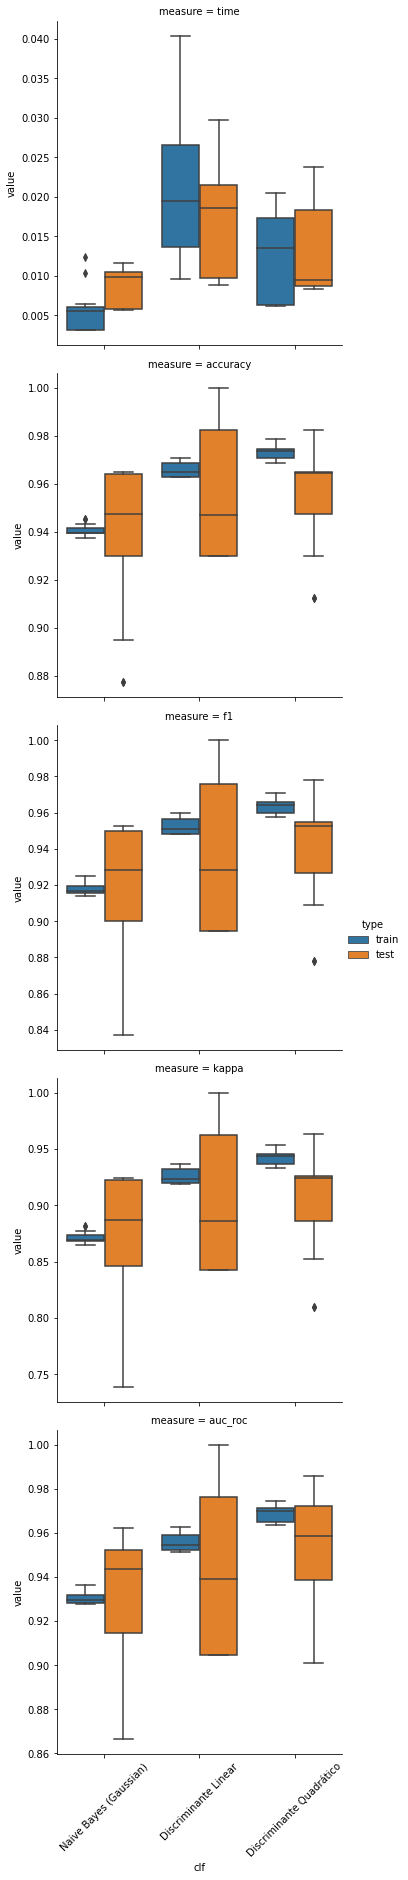

In [51]:
# Vamos plotar um grid de boxplots onde cada gráfico refere-se a uma métrica
# O eixo x dos gráficos indica os classificadores
g = sns.catplot(hue="type", y="value", kind="box", row='measure', x='clf', data=results, sharey=False)
g.set_xticklabels(rotation=45)

## 5 - Matriz de confusão e Curva ROC

Além das medidas de desempenho, podemos também olhar a [matriz de confusão](https://www.bioinfo.ufpr.br/moodle/pluginfile.php/725/mod_resource/content/0/05_matriz_de_confusao.pdf) e a curva [ROC](https://www.sanarmed.com/curva-roc-isso-realmente-faz-diferenca-colunistas). 

Para isso, vamos carregar uma outra base de dados e usar apenas uma divisão entre treino e teste.

### 5.1 - Importando e conhecendo os dados

In [52]:
# Importação dos dados também da openml, dessa vez o dataset é sobre diabetes
diabets = fetch_openml(data_id=37)
X_train, X_test, y_train, y_test = train_test_split(diabets.data, diabets.target, test_size=0.33, random_state=42)

In [53]:
# Distribuição das classes
Counter(diabets.target)

Counter({'tested_negative': 500, 'tested_positive': 268})

### 5.2 - Matriz de confusão

In [54]:
# Reaproveitando o dicionário de classificadores usado anteriormente
# Vamos calcular a matriz de confusão de cada cada classificador
cms = {}
for clf_name, clf in classificadores.items():
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  cms[clf_name] = confusion_matrix(y_test,y_pred)

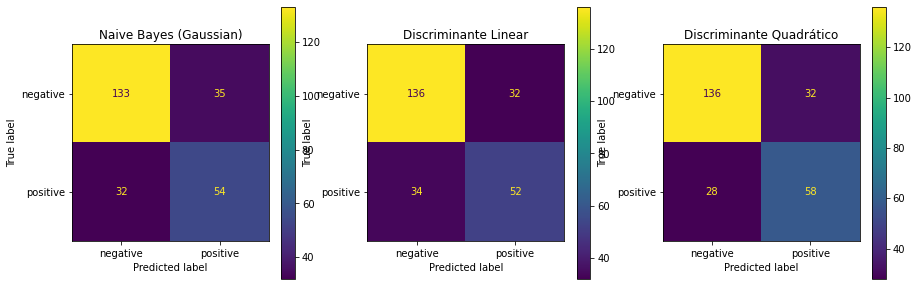

In [60]:
# Para visualizar as matrizes de confusão vamos usar um plot específico para isso
figure = plt.figure(figsize=(15, 5))
for i, (clf_name, cm) in enumerate(cms.items()):
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['negative','positive'])
  ax = plt.subplot(1,3,i+1)
  disp.plot(ax=ax,values_format="d")
  ax.set_title(clf_name)

### 5.3 - Curva ROC

In [61]:
# Vamos calcular curvas ROC para os três classificadores usados
# Mais uma vez usamos o dicionário de classificadores
curves = {}
for clf_name, clf in classificadores.items():
  # Fazendo o fit do classificador
  clf.fit(X_train,y_train)
  # Calculando o score com predict_proba que calcula a probabilidade de pertencer à classe positiva
  y_score = clf.predict_proba(X_test)[:,1]
  # Calculando as taxas de falso positivo e verdadeiro positivo
  fpr, tpr, _ = roc_curve(y_test, y_score, pos_label='tested_positive')
  roc_auc = roc_auc_score(y_test,y_score)
  curves[clf_name] = (fpr,tpr,roc_auc)

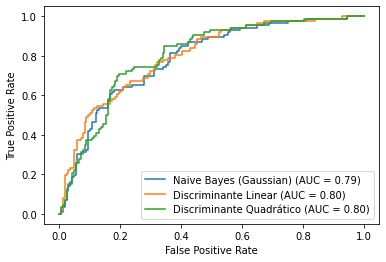

In [62]:
# Obtivemos três curvas no processo acima, vamos agora plotá-las
fig, ax = plt.subplots()
for clf_name, (fpr, tpr, roc_auc) in curves.items():
  curve = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=clf_name).plot(ax = ax)